### Importing Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import IsolationForest, StackingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from flaml import AutoML
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import joblib

### Reading dataset from excel file

In [2]:
df = pd.read_excel("./Crawler/cases.xlsx", index_col= 0)
df.head(3)

,title,description,zone,area,year,number of rooms,pish1,rent1,pish2,rent2,level,elevator,parking,warehouse,url
0,141 متری 6ساله در تاپ لوکیشن شهرک غرب,از ساعت 8 صبح تا 2 شب پاسخگو هستم\n\n141 متری ...,شهرک غرب,141,1397,3,1500000000,24000000.0,NaN,NaN,1,True,True,True,https://divar.ir/v/141-متری-6ساله-در-تاپ-لوکیش...
1,کامرانیه شمالی ١٣٠ متر فول فرنیش مبله,سلام عرض ادب \nکامرانیه شمالی \n١٣٠ متر یک خوا...,کامرانیه,130,1390,1,2350000000,10000000.0,1500000000,40000000.0,1,True,True,True,https://divar.ir/v/کامرانیه-شمالی-١٣٠-متر-فول-...
2,150متر/فول بازسازی/ویو تهران/بلوار24متری,⭐این آگهی شاید آپارتمان دلخواه شماست⭐\n\n✅150 ...,سعادت‌آباد,150,1389,3,2500000000,0.0,1500000000,30000000.0,6,True,True,True,https://divar.ir/v/150متر-فول-بازسازی-ویو-تهرا...


### Defining a target variable and replacing it with rent & pish columns <br>
"full mortgage" is defined based on mortgage and monthly rent (3,000,000 Tomans monthly rent = 100,000,000 Tomans mortgage)

In [3]:
df["full mortgage"] = df["pish1"].astype(float) + df["rent1"].astype(float) * 100/3
df.drop(["pish1", "pish2", "rent1", "rent2"], axis= 1, inplace= True)
df = df[(df["full mortgage"] > 10000000)].reset_index(drop= True)
df.head(3)

,title,description,zone,area,year,number of rooms,level,elevator,parking,warehouse,url,full mortgage
0,141 متری 6ساله در تاپ لوکیشن شهرک غرب,از ساعت 8 صبح تا 2 شب پاسخگو هستم\n\n141 متری ...,شهرک غرب,141,1397,3,1,True,True,True,https://divar.ir/v/141-متری-6ساله-در-تاپ-لوکیش...,2.300000e+09
1,کامرانیه شمالی ١٣٠ متر فول فرنیش مبله,سلام عرض ادب \nکامرانیه شمالی \n١٣٠ متر یک خوا...,کامرانیه,130,1390,1,1,True,True,True,https://divar.ir/v/کامرانیه-شمالی-١٣٠-متر-فول-...,2.683333e+09
2,150متر/فول بازسازی/ویو تهران/بلوار24متری,⭐این آگهی شاید آپارتمان دلخواه شماست⭐\n\n✅150 ...,سعادت‌آباد,150,1389,3,6,True,True,True,https://divar.ir/v/150متر-فول-بازسازی-ویو-تهرا...,2.500000e+09


### Creating a pair plot to check the relations between variables

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


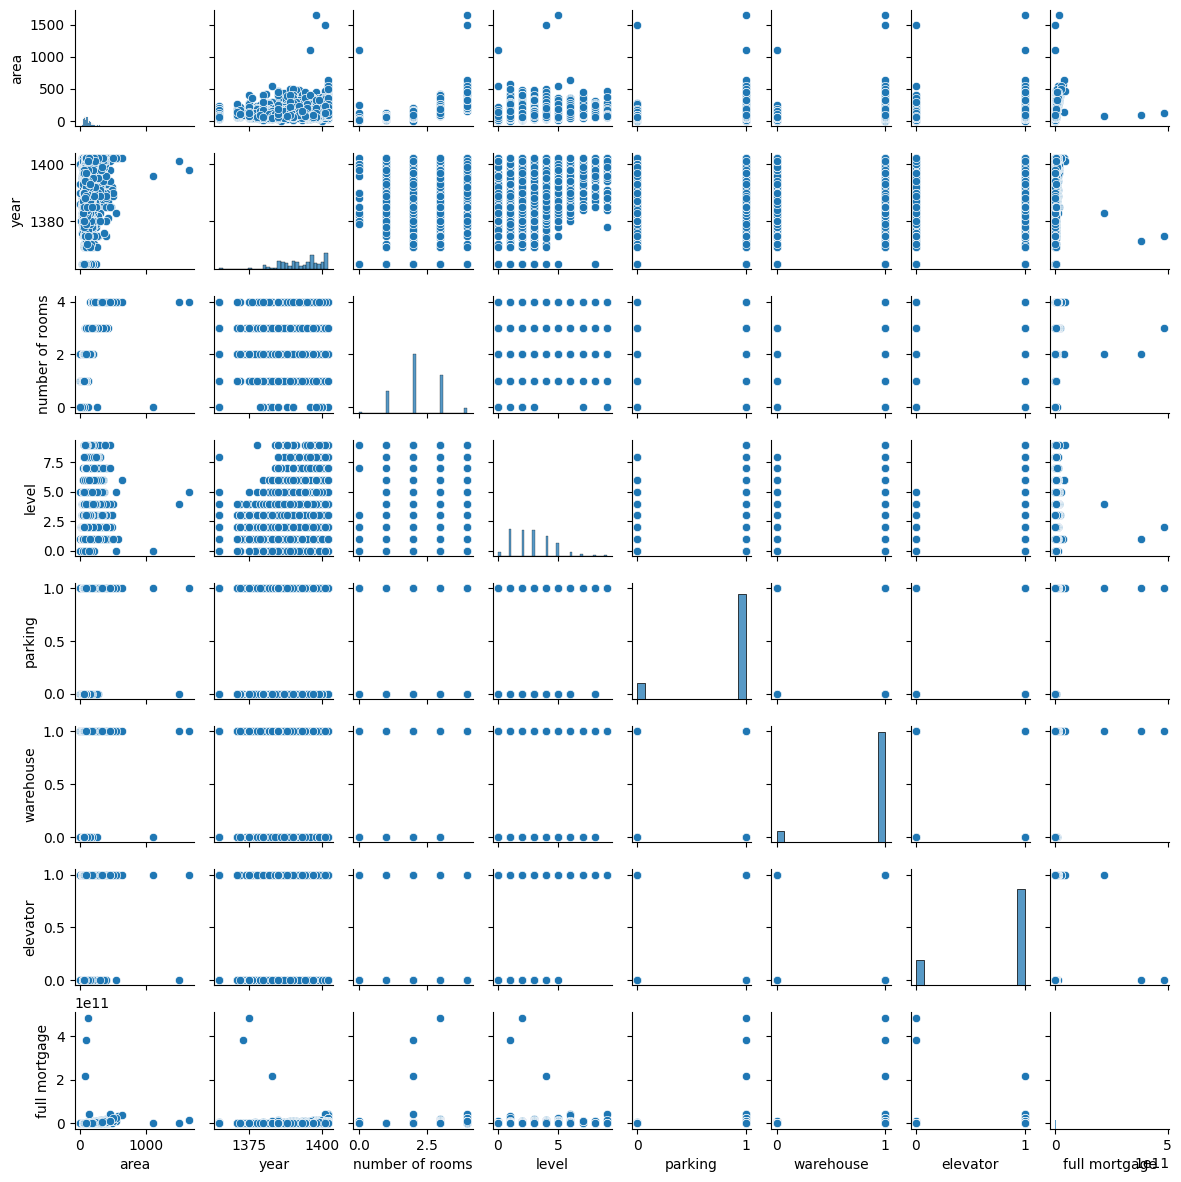

In [4]:
pairplot = sns.pairplot(df[["area", "year","number of rooms", "level", "parking", "warehouse", "elevator", "full mortgage"]], height= 1.5, aspect= 1)
plt.show()

### Creating a correlation matrix heatmap to check the relations between variables

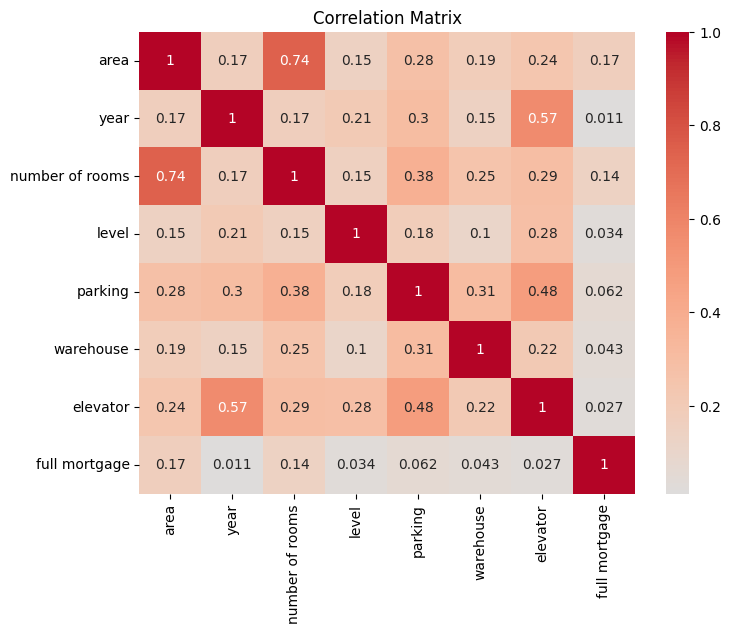

In [5]:
correlation_matrix = df[["area", "year", "number of rooms", "level", "parking", "warehouse", "elevator", "full mortgage"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

We can see that there are many outliers affecting the correlations (wrong price, wrong area, ...)

### Outlier detection using Isolation Forest

In [6]:
def outlier_removal(df):
    contamination = 0.15
    outlier_detection_model = IsolationForest(contamination=contamination, random_state=42)
    outlier_detection_model.fit(df[["elevator", "parking", "warehouse", "full mortgage", "year", "area"]])
    anomaly_scores = outlier_detection_model.decision_function(df[["elevator", "parking", "warehouse", "full mortgage", "year", "area"]])
    upthreshold = np.percentile(anomaly_scores, 98)
    downthreshold = np.percentile(anomaly_scores, 6)
    outliers = np.where((anomaly_scores > upthreshold)|(anomaly_scores < downthreshold))[0]
    df.iloc[outliers].sort_values(by= 'full mortgage', ascending= False).head(5)
    return outliers, anomaly_scores, outlier_detection_model

In [7]:
outliers, anomaly_scores, outlier_detection_model = outlier_removal(df)

### Distribution chart for anomaly scores

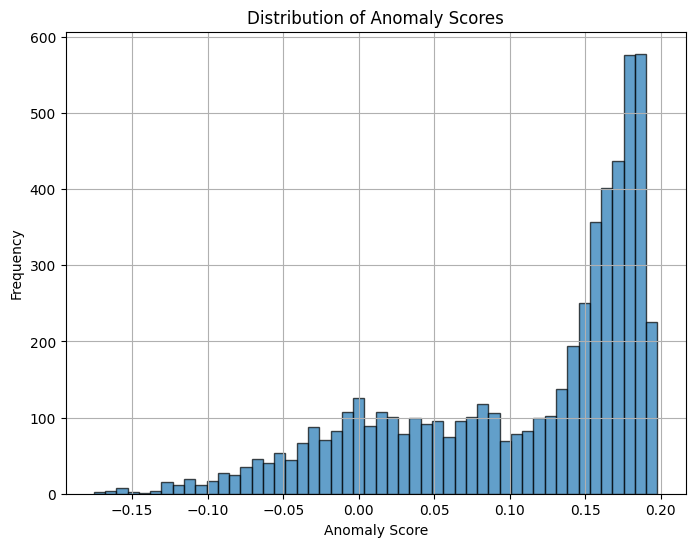

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(anomaly_scores, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Removing detected outliers

In [9]:
model_array = df.drop(index= outliers, axis=0)

### Creating a pair plot to check the relations between variables after removing outliers

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


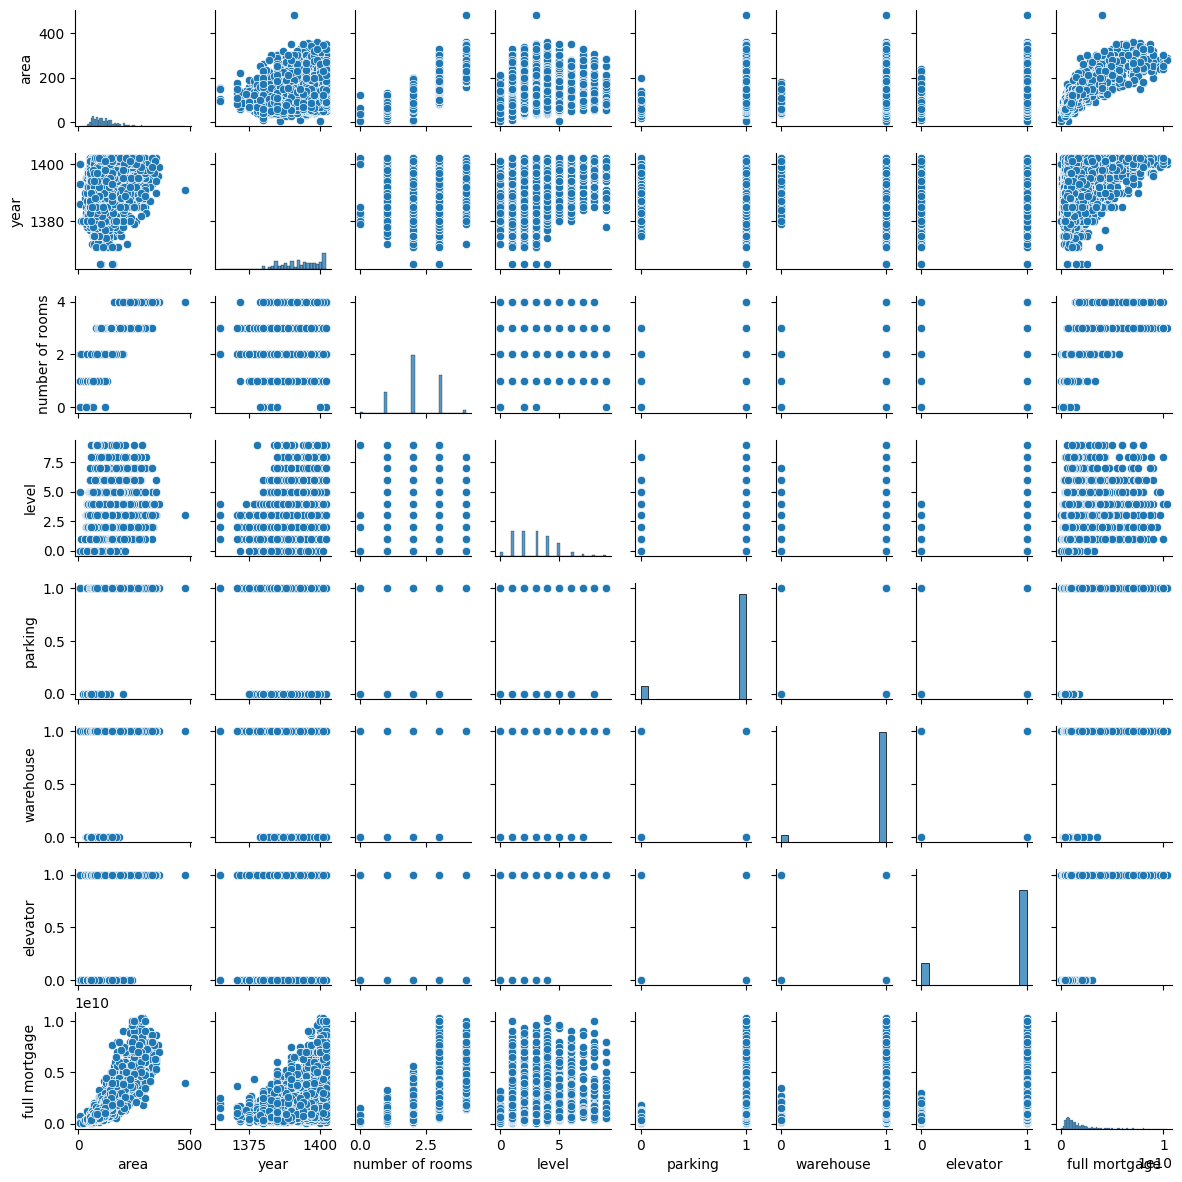

In [10]:
pairplot = sns.pairplot(model_array[["area", "year","number of rooms", "level", "parking", "warehouse", "elevator", "full mortgage"]], height= 1.5, aspect= 1)
plt.show()

### Creating a correlation matrix heatmap to check the relations between variables after removing the outliers

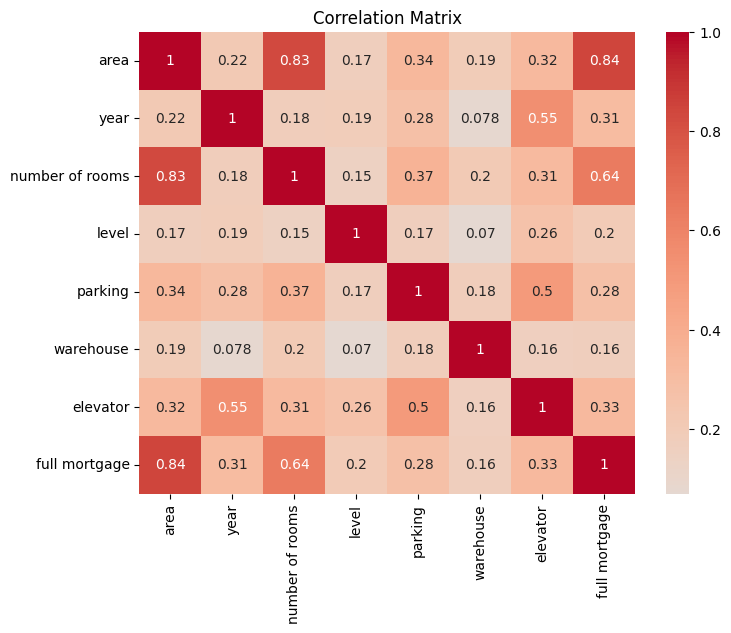

In [11]:
correlation_matrix = model_array[["area", "year", "number of rooms", "level", "parking", "warehouse", "elevator", "full mortgage"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

### Creating polynomial features for year and area

In [12]:
poly = PolynomialFeatures(degree=3)
year_poly = pd.DataFrame(poly.fit_transform(model_array[["year"]]), columns= ["intercept", "year", "year2", "year3"])
area_poly = pd.DataFrame(poly.fit_transform(model_array[["area"]]), columns= ["intercept_area", "area", "area2", "area3"]).drop(["intercept_area"], axis = 1)
model_array = pd.concat([model_array.drop(["year", "area"], axis = 1).reset_index(drop= True), year_poly, area_poly], axis= 1)
model_array.head(3)

,title,description,zone,number of rooms,level,elevator,parking,warehouse,url,full mortgage,intercept,year,year2,year3,area,area2,area3
0,141 متری 6ساله در تاپ لوکیشن شهرک غرب,از ساعت 8 صبح تا 2 شب پاسخگو هستم\n\n141 متری ...,شهرک غرب,3,1,True,True,True,https://divar.ir/v/141-متری-6ساله-در-تاپ-لوکیش...,2.300000e+09,1.0,1397.0,1951609.0,2.726398e+09,141.0,19881.0,2803221.0
1,کامرانیه شمالی ١٣٠ متر فول فرنیش مبله,سلام عرض ادب \nکامرانیه شمالی \n١٣٠ متر یک خوا...,کامرانیه,1,1,True,True,True,https://divar.ir/v/کامرانیه-شمالی-١٣٠-متر-فول-...,2.683333e+09,1.0,1390.0,1932100.0,2.685619e+09,130.0,16900.0,2197000.0
2,150متر/فول بازسازی/ویو تهران/بلوار24متری,⭐این آگهی شاید آپارتمان دلخواه شماست⭐\n\n✅150 ...,سعادت‌آباد,3,6,True,True,True,https://divar.ir/v/150متر-فول-بازسازی-ویو-تهرا...,2.500000e+09,1.0,1389.0,1929321.0,2.679827e+09,150.0,22500.0,3375000.0


### Encoding the categiorical variables corresponding neighbourhood using one-hot-encoding technique

In [13]:
model_array = pd.concat([model_array.drop("zone", axis= 1), pd.get_dummies(model_array["zone"])],axis= 1)
model_array.head(3)

,title,description,number of rooms,level,elevator,parking,warehouse,url,full mortgage,intercept,...,کوی فراز,کوی فردوس,کوی مهران,گاندی,گرگان,گلچین,گمرک,گیشا (کوی نصر),یافت‌آباد,یوسف‌آباد
0,141 متری 6ساله در تاپ لوکیشن شهرک غرب,از ساعت 8 صبح تا 2 شب پاسخگو هستم\n\n141 متری ...,3,1,True,True,True,https://divar.ir/v/141-متری-6ساله-در-تاپ-لوکیش...,2.300000e+09,1.0,...,False,False,False,False,False,False,False,False,False,False
1,کامرانیه شمالی ١٣٠ متر فول فرنیش مبله,سلام عرض ادب \nکامرانیه شمالی \n١٣٠ متر یک خوا...,1,1,True,True,True,https://divar.ir/v/کامرانیه-شمالی-١٣٠-متر-فول-...,2.683333e+09,1.0,...,False,False,False,False,False,False,False,False,False,False
2,150متر/فول بازسازی/ویو تهران/بلوار24متری,⭐این آگهی شاید آپارتمان دلخواه شماست⭐\n\n✅150 ...,3,6,True,True,True,https://divar.ir/v/150متر-فول-بازسازی-ویو-تهرا...,2.500000e+09,1.0,...,False,False,False,False,False,False,False,False,False,False


### Separating X, and Y variables

In [14]:
X = model_array.drop(["full mortgage", "title", "description", "url", "number of rooms", "area3"], axis = 1)
y = model_array["full mortgage"]
X.head(5)
X_cols = X.columns.tolist()

### Train-test splitting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standard scaling the variables

In [16]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.transform(X)

### Creating a new dataset using Principal component analysis, or PCA

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.97)
pca_X_train = pca.fit_transform(scaled_X_train)
pca_X_test = pca.transform(scaled_X_test)
pca_X = pca.transform(scaled_X)

### Defining metrics for calculating errors relative to the true target value
RMSEP (root mean square error percentage) is like RMSE (root mean sqaure error) but uses the (error / true value) instead of error itself to catch the errors for smaller values of target variable<br>MAEP (mean absolute error percentage) is like MAE (mean absolute error) but uses the (error / true value) instead of error itself to catch the errors for smaller values of target variable

In [18]:
def percentage_rmse(X_val, y_val, estimator, labels,
        X_train, y_train, weight_val=None, weight_train=None,
        config=None, groups_val=None, groups_train=None):
    start = time.time()
    y_pred = estimator.predict(X_val)
    pred_time = (time.time() - start) / len(X_val)
    val_rmsep = np.sqrt(np.mean(np.square(((y_val - y_pred) / np.minimum(y_val, y_pred)))))
    y_pred = estimator.predict(X_train)
    train_rmsep = np.sqrt(np.mean(np.square(((y_train - y_pred) / np.minimum(y_train, y_pred)))))
    return val_rmsep, {
        "val_rmsep": val_rmsep,
        "train_rmsep": train_rmsep,
        "pred_time": pred_time,
    }

In [19]:
def maximum_error_percentage(X_val, y_val, estimator, labels,
        X_train, y_train, weight_val=None, weight_train=None,
        config=None, groups_val=None, groups_train=None):
    start = time.time()
    y_pred = estimator.predict(X_val)
    pred_time = (time.time() - start) / len(X_val)
    val_mep = np.max(np.abs(y_val - y_pred) / np.minimum(y_val, y_pred))
    y_pred = estimator.predict(X_train)
    train_mep = np.max(np.abs(y_train - y_pred) / np.minimum(y_train, y_pred))
    return val_mep, {
        "val_rmsep": val_mep,
        "train_rmsep": train_mep,
        "pred_time": pred_time,
    }

In [20]:
def rmsep(y_true, y_pred):
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / np.minimum(y_true, y_pred)))))

In [21]:
def maep(y_true, y_pred):
    return np.mean(np.abs(((y_true - y_pred) / np.minimum(y_true, y_pred))))

In [22]:
def mep(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred) / np.minimum(y_true, y_pred))

### Defining a stacking generalization model that uses XGB Regressor, Random Forest Regressor, and Light GBM Regressor as base models and KNN Regressor as meta model and using cross-validation to train the model<br><br>Fitting the model using original dataset and pca dataset

In [23]:
base_models = [
    ('xgboost', XGBRegressor()),
    ('random_forest', RandomForestRegressor()),
    ('lightgbm', LGBMRegressor())
]
stacking_model = StackingRegressor(estimators=base_models, final_estimator=KNeighborsRegressor(), cv= 5)
stacking_model.fit(scaled_X_train, y_train)
clear_output()
stacking_model

StackingRegressor(cv=5,
                  estimators=[('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            le...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('random_forest', RandomForestRegressor()),
                              ('lightgbm', LGBMRegressor())],
                  final_estimator=KNeighborsRegressor())

In [24]:
stack_predictions = stacking_model.predict(scaled_X_test)
print("r-squared score:\t", r2_score(np.array(y_test).reshape(-1,1), np.array(stack_predictions).reshape(-1,1)))
print("RMSEP:          \t", rmsep(y_test, stack_predictions))
print("MAEP:           \t", maep(y_test, stack_predictions))
print("MaxEP:            \t", mep(y_test, stack_predictions))

r-squared score:	 0.8241801529764059
RMSEP:          	 0.4330323825799085
MAEP:           	 0.22731883497877256
MaxEP:            	 8.999999999999998


In [25]:
base_models = [
    ('xgboost', XGBRegressor()),
    ('random_forest', RandomForestRegressor()),
    ('lightgbm', LGBMRegressor())
]
stacking_model_pca = StackingRegressor(estimators=base_models, final_estimator=KNeighborsRegressor(), cv= 5)
stacking_model_pca.fit(pca_X_train, y_train)
clear_output()
stacking_model_pca

StackingRegressor(cv=5,
                  estimators=[('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            le...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('random_forest', RandomForestRegressor()),
                              ('lightgbm', LGBMRegressor())],
                  final_estimator=KNeighborsRegressor())

In [26]:
stack_pca_predictions = stacking_model_pca.predict(pca_X_test)
print("r-squared score:\t", r2_score(np.array(y_test).reshape(-1,1), np.array(stack_pca_predictions).reshape(-1,1)))
print("RMSEP:          \t", rmsep(y_test, stack_pca_predictions))
print("MAEP:           \t", maep(y_test, stack_pca_predictions))
print("MaxEP:            \t", mep(y_test, stack_pca_predictions))

r-squared score:	 0.845043974951836
RMSEP:          	 0.5145280680949712
MAEP:           	 0.24513692105531726
MaxEP:            	 11.18181818181818


### Defining a AutoML model using FLAML library Light GBM Regressor to train the model<br><br>Fitting the model using original dataset and pca dataset

In [27]:
auto_model = AutoML()
auto_model.fit(X_train= scaled_X_train, y_train= y_train, task= "regression", time_budget= 300, metric= percentage_rmse, estimator_list= ["lgbm"])
clear_output()
auto_model.best_config

{'n_estimators': 1126,
 'num_leaves': 17,
 'min_child_samples': 3,
 'learning_rate': 0.0642928893710019,
 'log_max_bin': 10,
 'colsample_bytree': 0.5483211805545062,
 'reg_alpha': 0.017695063811033893,
 'reg_lambda': 1.0931422599334393}

In [28]:
auto_predictions = auto_model.predict(scaled_X_test)
print("r-squared score:\t", r2_score(np.array(y_test).reshape(-1,1), np.array(auto_predictions).reshape(-1,1)))
print("RMSEP:          \t", rmsep(y_test, auto_predictions))
print("MAEP:           \t", maep(y_test, auto_predictions))
print("MaxEP:            \t", mep(y_test, auto_predictions))

r-squared score:	 0.8549395248725976
RMSEP:          	 0.5535527428099879
MAEP:           	 0.21916700738836312
MaxEP:            	 8.974293802747955


In [29]:
auto_model_pca = AutoML()
auto_model_pca.fit(X_train= pca_X_train, y_train= y_train, task= "regression", time_budget= 300, metric= percentage_rmse, estimator_list= ["lgbm"])
clear_output()
auto_model_pca.best_config

{'n_estimators': 951,
 'num_leaves': 22,
 'min_child_samples': 2,
 'learning_rate': 0.03611368405283794,
 'log_max_bin': 10,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.018284708726554213,
 'reg_lambda': 0.0015616453924167499}

In [30]:
auto_pca_predictions = auto_model_pca.predict(pca_X_test)
print("r-squared score:\t", r2_score(np.array(y_test).reshape(-1,1), np.array(auto_pca_predictions).reshape(-1,1)))
print("RMSEP:          \t", rmsep(y_test, auto_pca_predictions))
print("MAEP:           \t", maep(y_test, auto_pca_predictions))
print("MaxEP:            \t", mep(y_test, auto_pca_predictions))

r-squared score:	 0.8737809715824061
RMSEP:          	 0.5973275281633548
MAEP:           	 0.22858443499888015
MaxEP:            	 13.004957241073123


In [31]:
auto_model_max = AutoML()
auto_model_max.fit(X_train= scaled_X_train, y_train= y_train, task= "regression", time_budget= 300, metric= maximum_error_percentage, estimator_list= ["lgbm"])
clear_output()
auto_model_max.best_config

{'n_estimators': 1955,
 'num_leaves': 4,
 'min_child_samples': 4,
 'learning_rate': 0.23758689491640142,
 'log_max_bin': 10,
 'colsample_bytree': 0.7256942244994735,
 'reg_alpha': 0.0009765625,
 'reg_lambda': 0.013841339179334741}

In [32]:
auto_predictions_max = auto_model_max.predict(scaled_X_test)
print("r-squared score:\t", r2_score(np.array(y_test).reshape(-1,1), np.array(auto_predictions_max).reshape(-1,1)))
print("RMSEP:          \t", rmsep(y_test, auto_predictions_max))
print("MAEP:           \t", maep(y_test, auto_predictions_max))
print("MaxEP:            \t", mep(y_test, auto_predictions_max))

r-squared score:	 0.8381113521740073
RMSEP:          	 1.2077142045442095
MAEP:           	 0.2506642176051542
MaxEP:            	 8.051302395870731


Creating an Excel file containing data points with the predicted target values by each model

In [33]:
stack_pred = stacking_model.predict(scaled_X)
stack_pca_pred = stacking_model_pca.predict(pca_X)
auto_pred = auto_model.predict(scaled_X)
auto_pca_pred = auto_model_pca.predict(pca_X)
auto_pred_max = auto_model_max.predict(scaled_X)

df_column_order = model_array.columns.tolist()
df_column_order.remove("full mortgage")
df_column_order.append("full mortgage")
model_array = model_array[df_column_order]
conc = pd.concat([model_array, pd.Series(stack_pred), pd.Series(stack_pca_pred), pd.Series(auto_pred), pd.Series(auto_pca_pred), pd.Series(auto_pred_max)], axis= 1)
conc.columns = conc.columns.tolist()[:-5] + ["prediction (stacking model)", "prediction (stacking model with pca)", "prediction (automl model)", "prediction (automl model with pca)", "prediction (automl model max error)"]
conc["stacking model error percentage"] = (conc["full mortgage"] - conc["prediction (stacking model)"]).abs() / conc["full mortgage"] * 100
conc["stacking model with pca error percentage"] = (conc["full mortgage"] - conc["prediction (stacking model with pca)"]).abs() / conc["full mortgage"] * 100
conc["automl model error percentage"] = (conc["full mortgage"] - conc["prediction (automl model)"]).abs() / conc["full mortgage"] * 100
conc["automl model with pca error percentage"] = (conc["full mortgage"] - conc["prediction (automl model with pca)"]).abs() / conc["full mortgage"] * 100
conc["automl model max error error percentage"] = (conc["full mortgage"] - conc["prediction (automl model max error)"]).abs() / conc["full mortgage"] * 100
conc.to_excel("final.xlsx")

In [34]:
joblib.dump(X_cols, "./objs/x_columns.jobllib")
joblib.dump(outlier_detection_model, "./objs/outlier_model.jobllib")
joblib.dump(auto_model, "./objs/trained_model.joblib")
joblib.dump(scaler, "./objs/x_scaler.joblib")
joblib.dump(percentage_rmse, "./objs/percentage_rmse.joblib")
joblib.dump(maximum_error_percentage, "./objs/maximum_error_percentage.joblib")
joblib.dump(rmsep, "./objs/rmsep.joblib")
joblib.dump(maep, "./objs/maep.joblib")
joblib.dump(mep, "./objs/mep.joblib")

['./objs/mep.joblib']